In [1]:
import os, shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.3.0
 GPU: /device:GPU:0


In [2]:
#the paths to change: (and also need to change number of prediciton column)

#model path
model_path = './models/saved_VGG16_AL_fullretrainFinal'

#raw images:
#aerial_folder = '../data/pics/raw/Florence_20180917a_jpgs/'
#aerial_folder = '../data/pics/raw/Michael_20181011a_jpgs/'
aerial_folder = '../data/pics/raw/Isaias_20200804a_jpgs/'

#import prediction csv
#preds_df = pd.read_csv('../data/tables/FlorenceSecondLabels20180917a.csv')
#preds_df = pd.read_csv('../data/tables/MichaelSecondLabels20181011a.csv')
preds_df = pd.read_csv('../data/tables/IsaiasSecondLabels20200804a.csv')

#new csv to save
#newpredcsv = '../data/tables/FlorenceThirdLabels20180917a.csv'
#newpredcsv = '../data/tables/MichaelThirdLabels20181011a.csv'
newpredcsv = '../data/tables/IsaiasThirdLabels20200804a.csv'

#ALPATH = '../data/pics/modeltoLabeler/roundThree/Florence/'
#ALPATH = '../data/pics/modeltoLabeler/roundThree/Michael/'
ALPATH = '../data/pics/modeltoLabeler/roundThree/Isaias/'

In [3]:
# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)

In [4]:
#load images from Directory
aerials = []
labels = []
for img in os.listdir(aerial_folder):
    #pull the name of the image
    labels.append(img)
    #pull the image
    img = os.path.join(aerial_folder, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size=(416,416))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    aerials.append(img)
    

In [5]:
#run through model for prediction
aerials = np.vstack(aerials)
wpreds = model.predict(aerials)
#print(wpreds)

(array([444., 270., 224., 179., 222., 300., 372., 363., 517., 591.]),
 array([3.2688866e-20, 9.9865660e-02, 1.9973132e-01, 2.9959700e-01,
        3.9946264e-01, 4.9932832e-01, 5.9919399e-01, 6.9905967e-01,
        7.9892528e-01, 8.9879096e-01, 9.9865663e-01], dtype=float32),
 <a list of 10 Patch objects>)

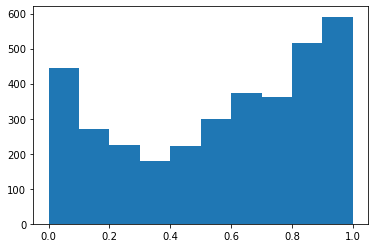

In [6]:
#just an idiot check
#np.histogram(wpreds)
fig,ax = plt.subplots(1,1)
ax.hist(wpreds, bins=10)

In [8]:
aerial_labels = np.vstack(np.asarray(labels))
#print(aerial_labels)

In [9]:
#make them a dataframe
newpred_df = pd.DataFrame(data=np.hstack((aerial_labels,wpreds)), columns=["image", "prediction2"])
#newpred_df

In [10]:
#append/join to catalog df and prediction via the 'image' column in hurricane.csv save as csv
preds = preds_df.join(newpred_df.set_index('image'), on='image')

#add two columns: washover, labeled
preds["washover"] = ""
preds["labeled"] = np.nan

preds.head()

,Unnamed: 0,file,storm_id,archive,image,size,date,lr_lon,ul_lat,ll_lat,ll_lon,ul_lon,geom_checksum,ur_lat,lr_lat,ur_lon,prediction,prediction2,washover,labeled
0,0,20200804a_jpgs/jpgs/S21776978.jpg,isaias,20200804a_jpgs,S21776978.jpg,6705271,2020/08/04,-79.889175,32.857442,32.854921,-79.895017,-79.913264,16b31b1f3d81d34022cc28f76a5cfb90,32.875906,32.866516,-79.904018,0.006467,0.10849977,,NaN
1,1,20200804a_jpgs/jpgs/S21766393.jpg,isaias,20200804a_jpgs,S21766393.jpg,6259383,2020/08/04,-75.959077,35.095388,35.086077,-75.970983,-75.985397,088ab652cbd4ed8ee48c712d7d0b3e20,35.107112,35.093768,-75.966710,0.753434,0.96936035,,NaN
2,2,20200804a_jpgs/jpgs/S21767012.jpg,isaias,20200804a_jpgs,S21767012.jpg,6009380,2020/08/04,-76.294318,34.863638,34.853882,-76.306386,-76.321875,db6d72612621b343057cea872f07e8e5,34.875547,34.861663,-76.302168,0.786389,0.94722056,,NaN
3,3,20200804a_jpgs/jpgs/S21775298.jpg,isaias,20200804a_jpgs,S21775298.jpg,5281908,2020/08/04,-79.351721,33.014702,33.004522,-79.365269,-79.371456,87f100dcdc56c94d80010dccbd82492c,33.019752,33.008178,-79.353651,0.641310,0.43755352,,NaN
4,4,20200804a_jpgs/jpgs/S21770086.jpg,isaias,20200804a_jpgs,S21770086.jpg,7279868,2020/08/04,-77.485597,34.457228,34.446724,-77.498370,-77.511211,c575a5c471b8be3efbb7fd4013a35c37,34.467243,34.453305,-77.491345,0.701684,0.9406317,,NaN


In [13]:
#make new column certainty of prediction, from 0 to 0.5... 0 is smallest certainty
preds["pred_certainty2"] = abs(preds["prediction2"].astype(float) - 0.5)

#select top 50 each that have not been labeled
uncertain_preds = preds[preds.labeled.isna()].nsmallest(100, 'pred_certainty2')

uncertain_preds.head()

maxval = max(uncertain_preds['pred_certainty2'])

#add labeled = 3 for all the images that will be labeled
preds.loc[(preds['pred_certainty2'] <= maxval) & (preds['labeled'].isna()), 'labeled'] = 3

preds.head()
#save the data
preds.to_csv(newpredcsv, index=False)

In [14]:
preds.head()

,Unnamed: 0,file,storm_id,archive,image,size,date,lr_lon,ul_lat,ll_lat,...,geom_checksum,ur_lat,lr_lat,ur_lon,prediction,prediction2,washover,labeled,pred_certainty,pred_certainty2
0,0,20200804a_jpgs/jpgs/S21776978.jpg,isaias,20200804a_jpgs,S21776978.jpg,6705271,2020/08/04,-79.889175,32.857442,32.854921,...,16b31b1f3d81d34022cc28f76a5cfb90,32.875906,32.866516,-79.904018,0.006467,0.10849977,,NaN,0.493533,0.391500
1,1,20200804a_jpgs/jpgs/S21766393.jpg,isaias,20200804a_jpgs,S21766393.jpg,6259383,2020/08/04,-75.959077,35.095388,35.086077,...,088ab652cbd4ed8ee48c712d7d0b3e20,35.107112,35.093768,-75.966710,0.753434,0.96936035,,NaN,0.253434,0.469360
2,2,20200804a_jpgs/jpgs/S21767012.jpg,isaias,20200804a_jpgs,S21767012.jpg,6009380,2020/08/04,-76.294318,34.863638,34.853882,...,db6d72612621b343057cea872f07e8e5,34.875547,34.861663,-76.302168,0.786389,0.94722056,,NaN,0.286389,0.447221
3,3,20200804a_jpgs/jpgs/S21775298.jpg,isaias,20200804a_jpgs,S21775298.jpg,5281908,2020/08/04,-79.351721,33.014702,33.004522,...,87f100dcdc56c94d80010dccbd82492c,33.019752,33.008178,-79.353651,0.641310,0.43755352,,NaN,0.141310,0.062446
4,4,20200804a_jpgs/jpgs/S21770086.jpg,isaias,20200804a_jpgs,S21770086.jpg,7279868,2020/08/04,-77.485597,34.457228,34.446724,...,c575a5c471b8be3efbb7fd4013a35c37,34.467243,34.453305,-77.491345,0.701684,0.9406317,,NaN,0.201684,0.440632


In [15]:
preds["prediction2"] = pd.to_numeric(preds["prediction2"])

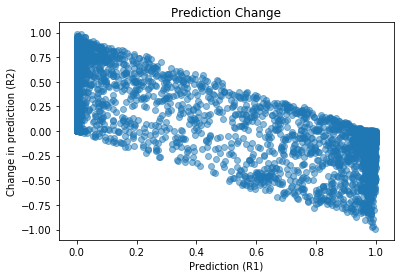

In [16]:
x = preds.prediction
y = (preds.prediction2 - preds.prediction)
plt.scatter(x, y, alpha=0.5)

plt.xlabel('Prediction (R1)')
plt.ylabel('Change in prediction (R2)')

plt.title("Prediction Change")

plt.show()

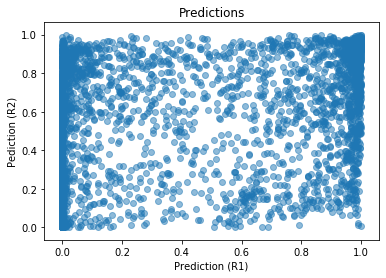

In [17]:
x = preds.prediction
y = (preds.prediction2 )
plt.scatter(x, y, alpha=0.5)

plt.xlabel('Prediction (R1)')
plt.ylabel('Pediction (R2)')

plt.title("Predictions")

plt.show()

In [18]:
#add the path
uncertain_preds['Image_Path'] = aerial_folder + uncertain_preds['image'].astype(str)

#pull out the list from the df
Labeled_list= uncertain_preds['Image_Path'].tolist()

#move those on the list
for f in Labeled_list:
    shutil.copy(f, ALPATH)